In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import RMtools_1D.do_QUfit_1D_mnest
import os
import shutil 
from pygdsm import GlobalSkyModel
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units
from tqdm import tqdm

In [2]:
parent_dir = '/srv/nmohamme/notebooks/FRII_git/QU-Fitting_depol/QU_results/' #Where you want the results saved

## This notebook interfaces with the RM-Tools QU-Fitting package.

Use plot_all_spectra.ipynb to visualize the results

In [3]:
fn = '/srv/nmohamme/fanregionII/data/chimeQ_kelvin_tadpolecutout.fits'
hdr_chimeq = fits.getheader(fn) 
chimeQ = fits.getdata(fn)

fn = '/srv/nmohamme/fanregionII/data/chimeU_kelvin_tadpolecutout.fits'
hdr_chimeu = fits.getheader(fn) 
chimeU = fits.getdata(fn)
wcs_chime = WCS(hdr_chimeu)

fn = '/srv/nmohamme/fanregionII/data/chimeI_kelvin_tadpolecutout.fits'
hdr_chimei = fits.getheader(fn) 
chimeI = fits.getdata(fn)

chime_freq = wcs_chime.wcs_pix2world(1, 1, np.arange(0, hdr_chimeq['NAXIS3'], 1), 1)[2]

In [4]:
chime_freqArr = wcs_chime.wcs_pix2world(1, 1, np.arange(0, hdr_chimeq['NAXIS3'], 1), 1)[2]
chime_waveArr2 = (3e8/chime_freqArr)**2
dwingeloo_wavelen2 = np.asarray([(3e8/chime_freqArr[825])**2,(3e8/chime_freqArr[679])**2,(3e8/chime_freqArr[297])**2])

In [5]:
fn = '/srv/nmohamme/fanregionII/data/gmims_u_frac_dragon_beam.fits'
hdr_gmims = fits.getheader(fn)
gmimsU = fits.getdata(fn)

fn = '/srv/nmohamme/fanregionII/data/gmims_q_frac_dragon_beam.fits'
gmimsQ = fits.getdata(fn)

wcs_gmims=WCS(hdr_gmims)

gmims_freq = wcs_gmims.wcs_pix2world(1, 1, np.arange(0, hdr_gmims['NAXIS3'], 1), 1, 1)[2]


In [6]:
#--- Load Dragons data, Dragons wcs, and array of Dragons frequencies
# This is a subset of the Dragons frequencies, low frequencies are not good enough to use yet

#--- Dragons WCS doesn't have the frequencies set, so we load them in seperate
file_path = '/srv/data/dragons/Mar2024_500_1000_MHz_cube/ListOfFrequencies_Hz.txt'
drag_freq = np.loadtxt(file_path)

#--- Convert Dragons from Jy/beam to Kelvin
jansk_to_K_drag = np.load('/srv/data/dva/JypK.npy')
unbinned_freq_drag = np.load('/srv/data/dva/abscalfreqs.npy')*1e6
indexes = np.searchsorted(unbinned_freq_drag, drag_freq)

fn = '/srv/data/dragons/Mar2024_500_1000_MHz_cube/DRAGONS_500_to_1024_q_cube_32bit_gal.fits'
hdr_dragq = fits.getheader(fn)
dragQ = fits.getdata(fn)
wcs_drag = WCS(hdr_dragq)

fn = '/srv/data/dragons/Mar2024_500_1000_MHz_cube/DRAGONS_500_to_1024_u_cube_32bit_gal.fits'
dragU = fits.getdata(fn)


a floating-point value was expected. [astropy.wcs.wcs]


In [7]:
# "anchoring" datasets

fn = '/home/nmohamme/FanRegionII/WMAP_data/wmap_band_iqumap_r9_9yr_K_v5.fits'
WMAP_data = fits.getdata(fn, exten_no=1)
hdr_WMAP_K = fits.getheader('/home/nmohamme/FanRegionII/WMAP_data/wmap_band_iqumap_r9_9yr_K_v5.fits')


fn = '/srv/nmohamme/fanregionII/data/COM_CompMap_QU-synchrotron-commander_2048_R3.00_full.fits'
planck_data = fits.getdata(fn,extent_no=1)
hdr_planck = fits.getheader(fn)

In [8]:
#We use the GlobalSky Model for the Stokes I across both GMIMS and Dragons
gsm = GlobalSkyModel(freq_unit='MHz')

In [9]:
##--- Currently these functions use the GlobalSkyModel to get the Stokes I across the GMIMS and Dragons data

def get_gmims_los(c):
    l = c.l.value
    b = c.b.value
    lpix = int(wcs_gmims.celestial.wcs_world2pix(l, b, 1)[0])
    bpix = int(wcs_gmims.celestial.wcs_world2pix(l, b, 1)[1])

    gdsm_I = []
    for f in tqdm(gmims_freq/1e6):
        gsm_temp = gsm.generate(f)
        gdsm_I.append(gsm_temp[hp.ang2pix(512, l, b, lonlat=True)])

    q = gmimsQ[:, bpix, lpix]/gdsm_I
    u = gmimsU[:, bpix, lpix]/gdsm_I

    return{'q':q, 'u':u, 'I':gdsm_I, 'lpix':lpix, 'bpix':bpix}

def get_chime_los(c):
    l = c.l.value
    b = c.b.value
    lpix = int(wcs_chime.celestial.wcs_world2pix(l, b, 1)[0])
    bpix = int(wcs_chime.celestial.wcs_world2pix(l, b, 1)[1])
    
    gdsm_I = []
    for f in tqdm(chime_freq/1e6):
        gsm_temp = gsm.generate(f)
        gdsm_I.append(gsm_temp[hp.ang2pix(512, l, b, lonlat=True)])
    
    I = np.asarray(gdsm_I)
        
    q = chimeQ[:, bpix, lpix]/I
    u = chimeU[:, bpix, lpix]/I
    
    return {'q':q, 'u':u, 'I':I}

def get_drag_los(c):
    l = c.l.value
    b = c.b.value
    lpix = int(wcs_drag.celestial.wcs_world2pix(l,b, 1)[0])
    bpix = int(wcs_drag.celestial.wcs_world2pix(l,b, 1)[1])

    gdsm_I = []
    for f in tqdm(drag_freq/1e6):
        gsm_temp = gsm.generate(f)
        gdsm_I.append(gsm_temp[hp.ang2pix(512, l,b, lonlat=True)])

    q = dragQ[:, bpix, lpix]/gdsm_I/jansk_to_K_drag[indexes]
    u = dragU[:, bpix, lpix]/gdsm_I/jansk_to_K_drag[indexes]

    return{'q':q, 'u':u, 'I':gdsm_I}

def get_WMAP_los(c):
    l = c.l.value
    b = c.b.value
    
    I = np.asarray(gsm.generate(22800)[hp.ang2pix(512, l,b, lonlat=True)])
    
    q = WMAP_data['Q_POLARISATION'][hp.ang2pix(512, l,b, lonlat=True)]/1000/I
    u = WMAP_data['U_POLARISATION'][hp.ang2pix(512, l,b, lonlat=True)]/1000/I
    p = np.sqrt(q**2+u**2)
    
    return{'p':p, 'q':q, 'u':u, 'I':I}


def get_planck_los(c):
    l = c.l.value
    b = c.b.value
    gsm_2048 = hp.ud_grade(gsm.generate(30000), nside_out=2048)
    I = np.asarray(gsm_2048[hp.ang2pix(2048, l,b, lonlat=True)])
    
    q = planck_data[hp.ang2pix(2048, l,b, lonlat=True)][0]/1000000/I
    u = planck_data[hp.ang2pix(2048, l,b, lonlat=True)][1]/1000000/I
    p = np.sqrt(q**2+u**2)
    
    return{'p':p, 'q':q, 'u':u, 'I':I}

In [10]:
data_freq = np.concatenate((drag_freq, gmims_freq))

'/srv/nmohamme/notebooks/FRII_git/QU-Fitting_depol/QU_results/140_5_m33_pymultinest_0.7_may2' created


100%|█████████████████████████████████████████████████████████████████████████████████| 409/409 [00:18<00:00, 22.61it/s]



Format [freq_Hz, Q, U,  dQ, dU]
Note: no Stokes I data - assuming fractional polarisation.
Plotting the input data and spectral index fit.

Loading the model from 'models_ns/m33.py' ...
Model could not be found! Please make sure model is present either in /srv/nmohamme/notebooks/FRII_git/models_ns/, or in /srv/envs/env_2024-02/lib/python3.11/site-packages/RMtools_1D/RMtools_1D/models_ns/


AttributeError: 'tuple' object has no attribute 'tb_frame'

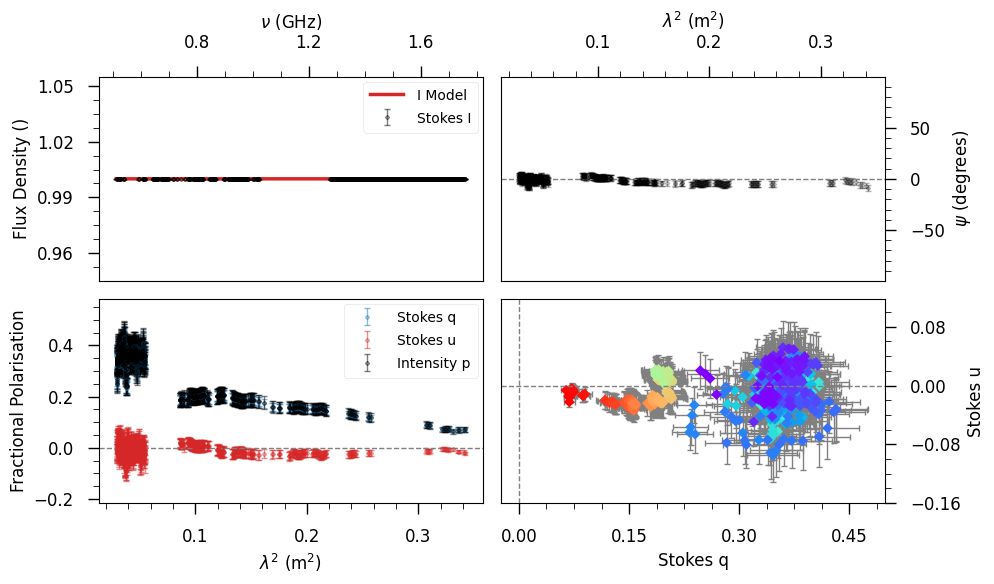

In [12]:
#---- Copy the below block into 'plot_all_spectra.ipynb' to visualize these specific results, otherwise manually
#---- enter the filename from the stores results in /QU_resuts/ 
#############################################################################################################################
#--- Some LOS to pick
clist = SkyCoord([130,136,140,134, 143.2,132, 150]*units.deg, [5.0,0,5,3.5, 7.6, 12, 20]*units.deg, frame='galactic')
sampler_used = 'pymultinest' #reccomended sampling model
model_used = 33 
drag_beam_eff= 0.7 #Beam efficiency for Dragons
note = f'may2' #Any notes you want to add to the directory name
#############################################################################################################################
anchor=False #If you want to anchor the fit to the WMAP/Planck
anchor_type = 'Planck' #WMAP or Planck

c = clist[2] # Set your LOS; you can instead loop over clist to do multiple LOS
directory = str(int(c.l.value)) + '_' + str(int(c.b.value))+'_m'+str(model_used)+'_'+str(sampler_used)+'_'+str(drag_beam_eff)+'_'+str(note)
path = parent_dir+directory
fn = path +'/qufit_' + str(int(c.l.value)) + '_' + str(int(c.b.value))
if os.path.exists(path):  # Check if directory exists
    if os.path.isdir(path):  # Check if it's a directory
        # Directory exists, so delete it
        shutil.rmtree(path)
        print(f"Directory '{path}' deleted.") 
    else:
        print(f"'{path}' exists but is not a directory.")
os.path.join(parent_dir, directory)
print(f"'{path}' created")

drag_los = get_drag_los(c)
gmims_los = get_gmims_los(c)
anchor_los, anchor_freq = (get_planck_los(c), 30e9) if anchor and anchor_type == 'Planck' else \
                          (get_WMAP_los(c), 22.8e9) if anchor and anchor_type == 'WMAP' else \
                          (None, None)

q = np.concatenate((drag_los['q']/drag_beam_eff, gmims_los['q'])) #factor of 0.7 is approximating beam efficiency
u = np.concatenate((drag_los['u']/drag_beam_eff, gmims_los['u']))
p = np.sqrt(q**2+u**2)
dq = p*0.1;du = p*0.1 #10% error is an estimate|

np.save(parent_dir+'/spectra_files/'+directory + 'qArr_' + str(int(c.l.value)) + '_' + str(int(c.b.value)), q)
np.save(parent_dir+'/spectra_files/'+directory +'uArr_' + str(int(c.l.value)) + '_' + str(int(c.b.value)), u)
np.save(parent_dir+'/spectra_files/'+directory +'freqArr_' + str(int(c.l.value)) + '_' + str(int(c.b.value)), data_freq)  #saved for plotting in plotting_models.ipynb

qufit_args = [data_freq, q, u, dq, du, anchor_los['p'], anchor_freq] if anchor else [data_freq, q, u, dq, du]
qufit_result = RMtools_1D.do_QUfit_1D_mnest.run_qufit(qufit_args, modelNum=model_used, prefixOut=fn, polyOrd=3, isTribble=anchor, noStokesI=True, sampler=sampler_used)

details = '''GMIMS-HBN convolved to Dragons 2.4 degree beam. 
'''
with open(path+'/details.txt', 'w') as f:
    f.write(details)